In [1]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [2]:
from langchain.tools import Tool
import requests
from bs4 import BeautifulSoup

def get_cost_of_living_info(location: str) -> str:
    """Fetches cost of living information for a given location."""
    try:
        url = f"https://www.numbeo.com/cost-of-living/in/{location.replace(' ', '-')}"
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")

        div = soup.find(
            'div', 
            {'class': 'seeding-call table_color summary limit_size_ad_right padding_lower other_highlight_color'}
        )
        return div.text.strip() if div else "Cost of living data not found."
    
    except Exception as e:
        return f"Error fetching data for {location}: {str(e)}"

# Initialize the tool
cost_of_living_info_tool = Tool(
    name="get_cost_of_living_info",
    func=get_cost_of_living_info,
    description="Fetches cost of living information for a given location."
)

get_cost_of_living_info(location="Berlin")

'Summary of cost of living in Berlin, Germany:The estimated monthly costs for a family of four are 3,886.0$ (3,417.1€), excluding rent (using our estimator).The estimated monthly costs for a single person are 1,145.7$ (1,007.5€), excluding rent.Berlin is 34.3% less expensive than New York (excluding rent, see our cost of living index).Rent in Berlin is, on average, 66.6% lower than in New York.'

In [3]:
def get_quality_of_living_info(location: str) -> str:
    """Fetches dummy quality of living information for a given location."""
    location = location.replace(" ","-")
    quality_of_living = {
        "New-York": "High competition, high salary, best for finance & tech.",
        "San-Francisco": "Tech hub, many startups, expensive but high salaries.",
        "Austin": "Growing tech scene, affordable living.",
        "Berlin": "Strong finance, healthcare, and consulting job market."
    }

    return f"Quality of living in {location}: {quality_of_living[location]}"

# Initialize the tool
quality_of_living_info_tool = Tool(
    name="get_quality_of_living_info",
    func=get_quality_of_living_info,
    description="Fetches dummy quality of living information for a given location."
)

get_quality_of_living_info(location="Berlin")

'Quality of living in Berlin: Strong finance, healthcare, and consulting job market.'

In [4]:
def get_property_info(location: str) -> str:
    """Fetches property related information for a given location."""
    location = location.replace(" ","-")
    url = f"https://www.numbeo.com/property-investment/in/{location.replace(' ', '-')}"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    table = soup.find('table',class_="table_indices")
    rows = table.find_all('tr')
    data = f"Property Investment Data for {location}"
    for i in range(len(rows)):
        if i==0:
            continue
        tds = rows[i].find_all('td')
        td_data = tds[0].text+tds[1].text.replace("\n","")
        data = data+"; "+td_data

    return data

# Initialize the tool
property_info_tool = Tool(
    name="get_property_info",
    func=get_property_info,
    description="Fetches property related information for a given location."
)

get_property_info(location="Berlin")

'Property Investment Data for Berlin; Price to Income Ratio: 11.49; Mortgage as Percentage of Income: 82.49%; Loan Affordability Index: 1.21; Price to Rent Ratio - City Centre: 29.03; Price to Rent Ratio - Outside of Centre: 28.69; Gross Rental Yield (City Centre): 3.44%; Gross Rental Yield (Outside of Centre): 3.49%'

In [5]:
from langchain_groq import ChatGroq

chat = ChatGroq(model="llama3-8b-8192", verbose=True)
tools = [cost_of_living_info_tool, quality_of_living_info_tool, property_info_tool]
chat_with_tools = chat.bind_tools(tools)

In [6]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition

# Generate the AgentState and Agent graph
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def assistant(state: AgentState):
    return {
        "messages": [chat_with_tools.invoke(state["messages"])],
    }

## The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
alfred = builder.compile()

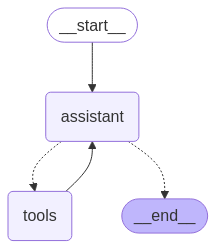

In [7]:
alfred

In [8]:
messages = [AIMessage(content="""
    You are an intelligent career decision specialist and have been provided with tools to compare -
        Cost of Living, Quality of Living and Property Investment Data 
    for provided locations and based on that give user which location they should choose and why.
    Your output should contain Final Comparison of -
        {Cost of living}, {Quality of living}, {Property Investment} for both cities
        Conclusion : Which city should I choose and why?
    """),
    HumanMessage(content="""
    I am currently a Data Scientist in Austin, and I have a new offer for a Senior Data Scientist position in Berlin.
    Should I take it?
    """)]
response = alfred.invoke({"messages": messages})

print("Alfred's Response:")
print(response['messages'][-1].content)

Alfred's Response:
<tool-use>{}</tool-use>

Based on the provided data, here's a comparison of the two cities:

Cost of Living: Austin is 36.9% less expensive than New York, while Berlin is 34.3% less expensive than New York. Berlin has a slightly lower cost of living, but both cities are relatively affordable.

Quality of Living: Austin has a growing tech scene and affordable living, while Berlin has a strong finance, healthcare, and consulting job market.

Property Investment: Berlin has a higher price-to-income ratio, mortgage as a percentage of income, and lower loan affordability index compared to Austin. However, Austin has a higher gross rental yield.

Considering your current role as a Data Scientist in Austin and the new offer for a Senior Data Scientist position in Berlin, I would recommend taking the offer in Berlin. Berlin's strong finance, healthcare, and consulting job market could provide more opportunities for growth and professional development. Additionally, Berlin's 

In [9]:
print(chat.invoke(messages[-1].content).content)

What an exciting decision! As a Data Scientist, you're likely considering factors beyond just the job title and salary. Here's a balanced analysis to help you weigh the pros and cons:

**Pros of taking the offer:**

1. **New challenge and growth**: A Senior Data Scientist role can bring new responsibilities, challenges, and opportunities for growth, which can be beneficial for your career.
2. **International experience**: Living and working in Berlin, Germany, can be a fantastic experience, providing you with a new cultural perspective and a broader network.
3. **Different industry or company**: If you're interested in exploring a new industry or company, this could be a great opportunity to do so.
4. **Language skills**: As German is an official language in Berlin, this could be a chance to improve your language skills or learn a new one.
5. **Cost of living**: Berlin has a relatively lower cost of living compared to Austin, which could mean more disposable income.

**Cons of taking t

In [10]:
response['messages']

[AIMessage(content='\n    You are an intelligent career decision specialist and have been provided with tools to compare -\n        Cost of Living, Quality of Living and Property Investment Data \n    for provided locations and based on that give user which location they should choose and why.\n    Your output should contain Final Comparison of -\n        {Cost of living}, {Quality of living}, {Property Investment} for both cities\n        Conclusion : Which city should I choose and why?\n    ', additional_kwargs={}, response_metadata={}, id='12a924db-34ff-4604-ab1f-ccc651918bce'),
 HumanMessage(content='\n    I am currently a Data Scientist in Austin, and I have a new offer for a Senior Data Scientist position in Berlin.\n    Should I take it?\n    ', additional_kwargs={}, response_metadata={}, id='f7614773-9edd-4d58-9d90-3dd7c9286a30'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kxxc', 'function': {'arguments': '{"__arg1":"Austin"}', 'name': 'get_cost_of_li